<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Pytorch_Workout_Convolutional_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MNIST Classification With Convolutional Network**

In [1]:
!pip3 install torch torchvision

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt

**Loading Data**

In [0]:
transforms = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

dataset_train = tv.datasets.MNIST('.', train = True, download = True, transform = transforms)
dataset_test = tv.datasets.MNIST('.', train = False, download = True, transform = transforms)

loader_train = t.utils.data.DataLoader(dataset_train, batch_size = 32, shuffle = True)
loader_test = t.utils.data.DataLoader(dataset_test, batch_size = 32, shuffle = False)

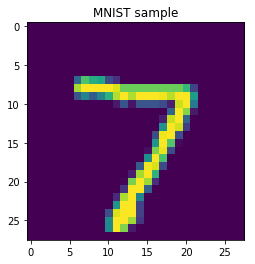

In [4]:
def plot_img(img):
  img = img.numpy()
  img = np.squeeze(img, axis = 0)
  plt.title('MNIST sample')
  plt.imshow(img)

imgs, labels = next(iter(loader_test))  
plot_img(imgs[0])

**Define Model**

In [0]:
class MNISTConvClassifier(t.nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv_1 = t.nn.Conv2d(
        in_channels = 1,
        out_channels = 20,
        kernel_size = 5,
        stride = 1,
        padding = 2
    )
    self.conv_2 = t.nn.Conv2d(
        in_channels = 20,
        out_channels = 50,
        kernel_size = 5,
        stride = 1,
        padding = 2
    )
    self.fc_1 = t.nn.Linear(7 * 7 * 50, 500)
    self.dropout_1 = t.nn.Dropout(0.5)
    self.fc_2 = t.nn.Linear(500, 10)
    
  def forward(self, x):
    x = t.nn.functional.relu(self.conv_1(x))
    x = t.nn.functional.max_pool2d(x, 2, 2)
    x = t.nn.functional.relu(self.conv_2(x))
    x = t.nn.functional.max_pool2d(x, 2, 2)
    x = x.view(x.shape[0], 7 * 7 * 50)
    x = t.nn.functional.relu(self.fc_1(x))
    x = self.dropout_1(x)
    x = self.fc_2(x)
    return x

**Training**

In [6]:
model = MNISTConvClassifier()
model = model.cuda()
epochs = 5
optimizer = t.optim.Adam(model.parameters(), 1e-4)
loss_fn = t.nn.CrossEntropyLoss()
losses_train = []
losses_valid = []
accuracies_train = []
accuracies_valid = []
len_valid_set = len(loader_test)

def accuracy(y_pred, y):
   max_vals, max_indx = t.max(y_pred, 1)
   return t.sum(max_indx == y).item() / len(y)

def train():
  # set in training mode, this affects dropout
  model.train() 
  for x, y in loader_train:
    x, y = x.cuda(), y.cuda()
    y_pred = model.forward(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses_train.append(loss.item())
    accuracies_train.append(accuracy(y_pred, y))

def validate():
  # set in evaluation mode, this affects dropout
  model.eval()
  with t.no_grad():
    total_loss = 0
    total_accuracy = 0
    for x, y in loader_test:
      x, y = x.cuda(), y.cuda()
      y_pred = model.forward(x)
      loss = loss_fn(y_pred, y)
      total_loss += loss.item()
      total_accuracy += accuracy(y_pred, y)
    losses_valid.append(total_loss / len_valid_set)
    accuracies_valid.append(total_accuracy / len_valid_set)
  
validate()
for i in range(epochs):
  train()
  validate()
  print('Finished epoch', i + 1)

Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5


**Plot Training**

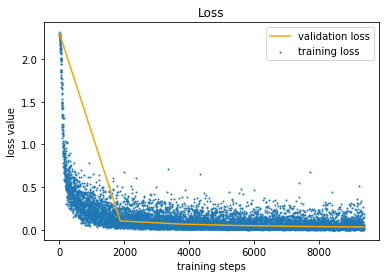

In [7]:
validation_markers = range(0, len(losses_train) + 1, len(loader_train))

plt.scatter(range(len(losses_train)), losses_train, s = 1, label = 'training loss')
plt.plot(validation_markers, losses_valid, color = 'orange', label = 'validation loss')
plt.title('Loss')
plt.xlabel('training steps')
plt.ylabel('loss value')
plt.legend()

Accuracy is 0.9897164536741214


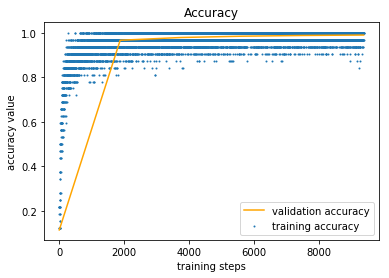

In [8]:
plt.scatter(range(len(accuracies_train)), accuracies_train, s = 1, label = 'training accuracy')
plt.plot(validation_markers, accuracies_valid, color = 'orange', label = 'validation accuracy')
plt.title('Accuracy')
plt.xlabel('training steps')
plt.ylabel('accuracy value')
plt.legend()

print('Accuracy is', accuracies_valid[-1])